# 11-experiment-three-cogsci

## Integrity

In [5]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

### Reading Data

In [6]:
GROUPS = 2
QUESTIONS = 5
JUDGMENTS = 6
SCORE_THRESHOLD = 240.9

FILE_NAMES = [
    'data/raw-3.json',
]

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)

In [7]:
def _get_group(score):
    if score < SCORE_THRESHOLD:
        return 0
    return 1

### Parsing Data

In [8]:
data = {
    'id': [],
    'consent': [],
    'attention': []
}

for g_num in range(GROUPS):
    for q_num in range(QUESTIONS):
        data['g{}_q{}_score'.format(g_num, q_num)] = []
        data['g{}_q{}_index'.format(g_num, q_num)] = []
        for j_num in range(JUDGMENTS):
            data['g{}_q{}_j{}'.format(g_num, q_num, j_num)] = []

In [9]:
ANSWER_KEYS = ('Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5')

for person in master_responses:
    # Grab data & ID
    person_data = person['data']  
    data['id'].append(person_data[0]['participantID'])
    
    # Fill in question labels
    question_scores = person_data[0]['questionScores']
    question_indices = person_data[0]['questionIndices']
    
    counters = [0, 0]
    question_labels = []
    for score in question_scores:
        g_num = _get_group(score)
        question_labels.append('g{}_q{}'.format(g_num, counters[g_num]))
        counters[g_num] += 1
    
    for q_label, score in zip(question_labels, question_scores):
        data['{}_score'.format(q_label)].append(score)
    for q_label, index in zip(question_labels, question_indices):
        data['{}_index'.format(q_label)].append(index)
    
    # Get consent response
    consent_answer = json.loads(person_data[0]['responses'])
    consent_value = int(consent_answer['Q0'].startswith('I consent'))
    data['consent'].append(consent_value)

    # Fill in judgments
    judgment_indices = person_data[0]['judgmentIndices']
    
    for q_label, likert_index in zip(question_labels, range(2, 14)):
        answer = json.loads(person_data[likert_index]['responses'])
        for j_label, key in zip(judgment_indices, ANSWER_KEYS):
            rating = int(answer[key])
            data['{}_j{}'.format(q_label, j_label)].append(rating)

    # Attention check
    attention_answer = json.loads(person_data[7]['responses'])
    attention_value = int(attention_answer['Q6'] == '6')
    data['attention'].append(attention_value)

### Reading Responses into Data

In [10]:
data = pd.DataFrame(data)
sample_size = len(data)
data.head()

,id,consent,attention,g0_q0_score,g0_q0_index,g0_q0_j0,g0_q0_j1,g0_q0_j2,g0_q0_j3,g0_q0_j4,...,g1_q3_j4,g1_q3_j5,g1_q4_score,g1_q4_index,g1_q4_j0,g1_q4_j1,g1_q4_j2,g1_q4_j3,g1_q4_j4,g1_q4_j5
0,sana26r21r9md90gqj3o7fm1rm4rpw2p,1,1,36,2,4,3,5,0,5,...,1,2,24039,40,3,2,4,5,1,5
1,68d2brqo4tuf7kstwx0evwcuu5hqf9o2,1,1,30,10,2,2,3,2,2,...,3,3,24051,0,1,3,1,1,1,1
2,rxt9ompoqypdk5v67wmwpseu29te3s08,1,1,14,32,6,2,5,2,3,...,5,5,24047,23,2,0,1,6,6,1
3,e4zr4k2wtn02qngsjapkp4w911s169qu,1,0,15,45,6,0,4,0,6,...,6,6,24051,21,6,6,0,3,6,0
4,wul66ydj8kvrksvrb3u57s0eap457scs,1,1,24,41,5,0,3,4,6,...,6,4,24032,42,2,0,4,6,5,4


In [11]:
print(len(data), data.size)
data = data[data.consent == 1]
print(len(data), data.size)
data = data[data.attention == 1]
print(len(data), data.size)

print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

264 21912
264 21912
243 20169
Inclusion: 92.05% 


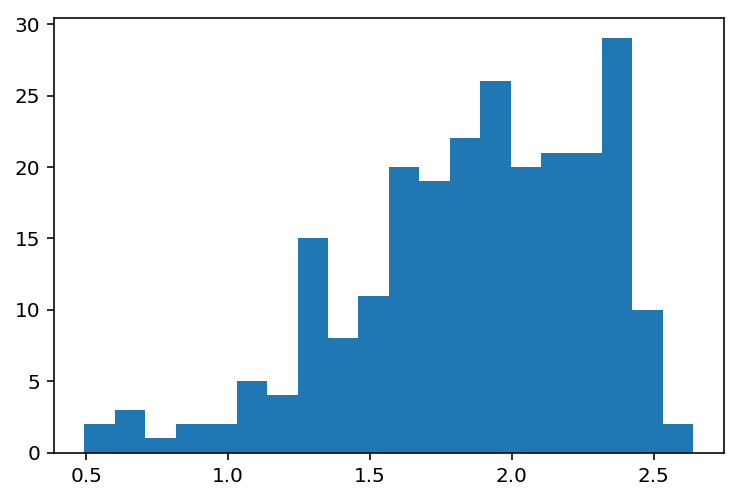

[[4 5 4 5 5 5 4 5 4 5 5 4 5 5 4 5 4 5 4 5 5 5 4 5 4 5 4 5 4 5 4 5 5 5 4 4
  5 5 4 4 5 5 5 5 4 5 4 5 5 5 4 5 4 5 4 4 5 5 5 4]]


/Users/hermish/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [12]:
judgments = []
for g_num in range(GROUPS):
    for q_num in range(QUESTIONS):
        for j_num in range(JUDGMENTS):
            judgments.append('g{}_q{}_j{}'.format(g_num, q_num, j_num))
scores = data[judgments]
data['j_mean'] = scores.mean(axis=1)
data['j_std'] =scores.std(axis=1)

plt.hist(data['j_std'], bins=20)
plt.show()

index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)

In [13]:
print(len(data), data.size)
data = data[data.j_std > 0.75]
index = np.argmin(data['j_std'])
print(scores.loc[[index]].values)
print('Inclusion: {:.4}% '.format(len(data) / sample_size * 100))

243 20655
[[4 5 3 4 4 3 4 4 4 3 4 3 4 5 3 4 4 4 3 5 4 5 4 3 4 5 4 5 4 3 4 5 4 5 4 3
  3 4 4 5 4 2 4 6 4 5 5 3 4 5 3 4 4 3 5 5 4 5 4 4]]
Inclusion: 90.15% 


### Saving Data

In [10]:
data.to_pickle('data/responses.pkl')